In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import GPy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
import time

SEED = 0

AT2 = ['AT2_04M_F0','AT2_04M_F10','AT2_18M_F0','AT2_18M_F10']
AM = ['AM_04M_F0','AM_04M_F10','AM_18M_F0','AM_18M_F10']
cell_lines = AT2+AM

In [2]:
with open('rna_protein_embeddings.pkl','rb') as file:
    rna_prot_embed = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'rna_protein_embeddings.pkl'

In [1]:
rna_prot_embed[cell_lines[0]]

NameError: name 'rna_prot_embed' is not defined

In [5]:
rna_prot_embed[cell_lines[1]]

,,,mRNA_TMM,ProteinAUC,ProteinLength,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
Gene.names,Majority.protein.IDs,cell,,,,,,,,,,,,,,,,,,,,,
Gnai3,Q9DC51,AT2_04M_F10,156.783470,4.696775e+07,354,-0.123134,0.126303,-0.092475,-0.969833,-0.005820,-0.057672,0.107903,...,0.137047,0.008167,-0.088351,-0.018563,-0.036717,0.443771,-0.123508,-0.036990,0.424119,0.014253
Cox5a,P12787,AT2_04M_F10,51.178770,8.007420e+08,146,0.014350,0.121865,-0.062778,-0.984908,-0.017123,-0.065598,0.056624,...,0.118580,0.009217,0.136575,-0.059452,0.019777,0.423250,-0.063350,-0.025512,0.384949,0.015145
Dlat,Q8BMF4,AT2_04M_F10,54.109481,1.148470e+08,642,-0.026584,0.109657,-0.081645,-0.963428,-0.030461,-0.162972,0.066631,...,0.138321,0.016578,0.122076,-0.143501,0.013228,0.302376,-0.168613,-0.036329,0.351341,-0.014426
Trim25,Q61510,AT2_04M_F10,187.350859,2.650903e+07,634,-0.071294,0.072918,-0.114657,-0.975195,-0.041038,-0.088154,0.031005,...,0.156678,0.041194,0.020387,-0.059393,-0.025968,0.263505,-0.113366,-0.038602,0.264744,0.012638
Hddc2,Q3SXD3,AT2_04M_F10,2.989516,1.007933e+07,199,-0.060917,0.106940,-0.081759,-0.987541,-0.041938,-0.047574,0.066603,...,0.117265,0.017000,0.048996,-0.060047,0.028098,0.415346,-0.117043,-0.002944,0.332298,0.043638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H1f0,P10922,AT2_04M_F10,212.321470,5.482941e+08,194,-0.225748,0.043310,-0.087645,-0.958192,-0.016585,-0.014059,0.020144,...,0.172665,-0.047817,0.058236,-0.358728,0.072748,0.262859,-0.376427,-0.060751,0.199526,0.070703
Psmb9,P28076,AT2_04M_F10,37.632818,5.021474e+07,219,0.008655,0.161174,-0.095418,-0.960228,-0.001615,-0.221773,0.072014,...,0.086866,0.005392,0.017854,-0.061520,-0.005442,0.363715,-0.135031,-0.037465,0.440352,-0.036961
Sowahc,Q8C0J6,AT2_04M_F10,3.325907,1.794102e+07,512,-0.048821,0.106069,-0.109359,-0.970515,-0.047805,-0.196038,0.059995,...,0.202381,0.039076,0.152250,-0.110805,0.024184,0.343852,-0.138716,-0.007629,0.205146,0.000572


###  GPy setup for proteins with their embeddings
* train/test for predictive testing?
* log transform of data? if log transfrom what is the correct way to evaulate performance and back-transformation?
* mean center and divide by std

In [3]:
def zscore(train_df):
    assert isinstance(train_df,pd.DataFrame)
    means = train_df.mean(axis=0)
    stds = train_df.std(axis=0)
    zscored = (train_df-means)/stds
    return zscored, means, stds

#### Train/test split and log2(x+1) transform on mRNA, protein and protein length

In [122]:
rna_prot_embed[cell_lines[0]]

,,,mRNA_TMM,ProteinAUC,ProteinLength,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
Gene.names,Majority.protein.IDs,cell,,,,,,,,,,,,,,,,,,,,,
Gnai3,Q9DC51,AT2_04M_F0,7.151432,25.389750,8.471675,-0.123134,0.126303,-0.092475,-0.969833,-0.005820,-0.057672,0.107903,...,0.137047,0.008167,-0.088351,-0.018563,-0.036717,0.443771,-0.123508,-0.036990,0.424119,0.014253
Cox5a,P12787,AT2_04M_F0,5.426985,29.676180,7.199672,0.014350,0.121865,-0.062778,-0.984908,-0.017123,-0.065598,0.056624,...,0.118580,0.009217,0.136575,-0.059452,0.019777,0.423250,-0.063350,-0.025512,0.384949,0.015145
Dlat,Q8BMF4,AT2_04M_F0,5.496820,26.982080,9.328675,-0.026584,0.109657,-0.081645,-0.963428,-0.030461,-0.162972,0.066631,...,0.138321,0.016578,0.122076,-0.143501,0.013228,0.302376,-0.168613,-0.036329,0.351341,-0.014426
Gpr107,Q8BUV8,AT2_04M_F0,6.244449,22.902280,9.108524,-0.027330,0.104179,0.021283,-0.953025,-0.020908,-0.239551,0.096819,...,0.127384,0.011998,0.039601,-0.030980,-0.080105,0.244611,-0.092342,-0.039188,0.482943,-0.018493
Trim25,Q61510,AT2_04M_F0,6.358683,24.415022,9.310613,-0.071294,0.072918,-0.114657,-0.975195,-0.041038,-0.088154,0.031005,...,0.156678,0.041194,0.020387,-0.059393,-0.025968,0.263505,-0.113366,-0.038602,0.264744,0.012638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H1f0,P10922,AT2_04M_F0,7.419878,28.773797,7.607330,-0.225748,0.043310,-0.087645,-0.958192,-0.016585,-0.014059,0.020144,...,0.172665,-0.047817,0.058236,-0.358728,0.072748,0.262859,-0.376427,-0.060751,0.199526,0.070703
Psmb9,P28076,AT2_04M_F0,3.389854,24.962038,7.781360,0.008655,0.161174,-0.095418,-0.960228,-0.001615,-0.221773,0.072014,...,0.086866,0.005392,0.017854,-0.061520,-0.005442,0.363715,-0.135031,-0.037465,0.440352,-0.036961
Sowahc,Q8C0J6,AT2_04M_F0,0.555332,23.859992,9.002815,-0.048821,0.106069,-0.109359,-0.970515,-0.047805,-0.196038,0.059995,...,0.202381,0.039076,0.152250,-0.110805,0.024184,0.343852,-0.138716,-0.007629,0.205146,0.000572


In [4]:
#Conduct for a single cell line - Train/Test split
rna_prot_embed[cell_lines[0]]['mRNA_TMM'] = np.log2(rna_prot_embed[cell_lines[0]]['mRNA_TMM']+1)
rna_prot_embed[cell_lines[0]]['ProteinAUC'] = np.log2(rna_prot_embed[cell_lines[0]]['ProteinAUC']+1)
rna_prot_embed[cell_lines[0]]['ProteinLength'] = np.log2(rna_prot_embed[cell_lines[0]]['ProteinLength']+1)
train, test = train_test_split(rna_prot_embed[cell_lines[0]], test_size=0.2, random_state=SEED)

#### Zscore data

In [5]:
train, train_mean, train_std = zscore(train) #zscore data
test = (test-train_mean)/train_std #zscore test data using mean and std from train set

#### Generate GPy model

In [6]:
#Initialize base kernel to use (ARD)
d = train.shape[1]-1 # input dimension
var = 1 # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)

In [7]:
x = train.loc[:,train.columns != 'ProteinAUC'].values
y = train.loc[:,train.columns == 'ProteinAUC'].values
time_start = time.time()
m = GPy.models.GPRegression(x,y,k)
print(f'run time {time.time()-time_start}')

run time 219.7858691215515


In [121]:
m.predict(x[0:10,:])[0]

array([[ 0.8435543 ],
       [-0.4373411 ],
       [-0.97749676],
       [-0.44477133],
       [ 1.03346305],
       [ 0.87254079],
       [ 1.87728358],
       [ 1.97199598],
       [-0.72417592],
       [ 0.07647816]])

In [120]:
y[0:10,:]

array([[ 1.78461312],
       [-0.5247875 ],
       [-0.85275332],
       [ 0.50701859],
       [ 1.84744297],
       [ 0.83432148],
       [ 1.84205606],
       [ 2.6511231 ],
       [-0.59112738],
       [ 0.38903037]])

In [8]:
print(m)


Name : GP regression
Objective : 4270.368672418932
Number of Parameters : 68
Number of Optimization Parameters : 68
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |  (66,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [11]:
time_start = time.time()
m.optimize(messages=False, ipython_notebook=True)
print(f'run time {time.time()-time_start}')
print(m)

run time 51624.727590322495

Name : GP regression
Objective : 3195.459693935532
Number of Parameters : 68
Number of Optimization Parameters : 68
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   1.6309436050961201  |      +ve      |        
  rbf.lengthscale          |                (66,)  |      +ve      |        
  Gaussian_noise.variance  |  0.49904552103863564  |      +ve      |        


In [12]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.6309436050961201,+ve,
rbf.lengthscale,"(66,)",+ve,
Gaussian_noise.variance,0.49904552103863564,+ve,


In [13]:
#saving model
#np.save('model_save.npy', m.param_array)
np.save('model_save_10_9.npy', m.param_array)

In [27]:
x_test = test.loc[:,train.columns != 'ProteinAUC'].values
y_test = test.loc[:,train.columns == 'ProteinAUC'].values

In [43]:
y_predicted = m.predict(x_test)
y_means = y_predicted[0]
y_vars = y_predicted[1]

In [83]:
thresh = 0.51

In [84]:
y_means[(y_vars<thresh).squeeze(),:].shape

(239, 1)

In [100]:
sMSE = mean_squared_error(y_test[(y_vars>thresh).squeeze(),:],y_means[(y_vars>thresh).squeeze(),:])/np.var(y_test[(y_vars>thresh).squeeze(),:])

In [102]:
mean_squared_error(y_test[(y_vars>thresh).squeeze(),:],y_means[(y_vars>thresh).squeeze(),:])

0.5945357349666157

In [103]:
y_means[(y_vars>thresh).squeeze(),:][0:10]

array([[ 0.97892889],
       [ 0.6994948 ],
       [-0.83580184],
       [ 2.05960566],
       [ 0.01576389],
       [-0.30893935],
       [-0.68784679],
       [-0.3935706 ],
       [ 0.36672142],
       [ 0.52835393]])

In [104]:
y_test[(y_vars>thresh).squeeze(),:][0:10]

array([[ 1.44507348],
       [ 1.4557387 ],
       [-0.71826614],
       [ 3.44376903],
       [-1.11730791],
       [-0.9781521 ],
       [-0.4054699 ],
       [-0.58594405],
       [ 1.73364897],
       [ 0.34452326]])

In [98]:
m.predict(x_test[7,:][None,:])

(array([[-0.5870151]]), array([[0.50777419]]))

In [99]:
y_test[7,:]

array([0.45697943])

In [101]:
sMSE

0.5622076134147719

In [105]:
scipy.stats.spearmanr(y_test[(y_vars>thresh).squeeze(),:],y_means[(y_vars>thresh).squeeze(),:])

SpearmanrResult(correlation=0.6141312680397983, pvalue=4.585277952559653e-50)

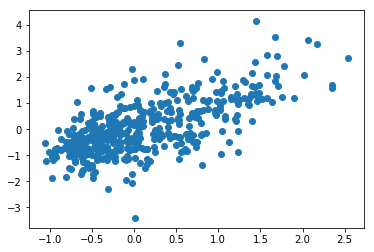

In [106]:
plt.scatter(y_means[(y_vars>thresh).squeeze(),:],y_test[(y_vars>thresh).squeeze(),:])

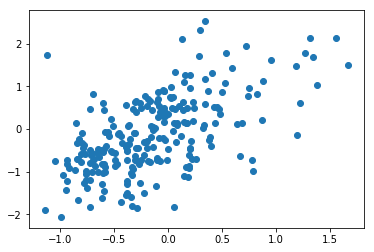

In [107]:
plt.scatter(y_means[(y_vars<thresh).squeeze(),:],y_test[(y_vars<thresh).squeeze(),:])

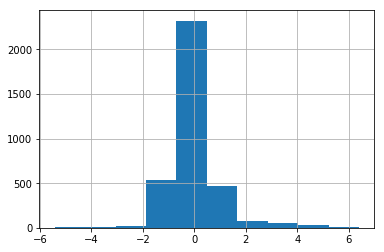

In [52]:
((rna_prot_embed['AT2_04M_F0'].loc[:,2]-(rna_prot_embed['AT2_04M_F0'].loc[:,2].mean()))/(rna_prot_embed['AT2_04M_F0'].loc[:,2].std())).hist()

In [43]:
rna_prot_embed['AT2_04M_F0'].loc[:,'mRNA_TMM'].sort_values()[0:10]

Gene.names  Majority.protein.IDs  cell      
Timm8a1     Q9WVA2                AT2_04M_F0    0.009108
Grm5        Q3UVX5                AT2_04M_F0    0.308224
Rab4b       Q91ZR1                AT2_04M_F0    0.318530
Vim         P20152                AT2_04M_F0    0.379449
Anxa9       Q9JHQ0                AT2_04M_F0    0.404886
Pag1        Q3U1F9                AT2_04M_F0    0.433763
Sowahc      Q8C0J6                AT2_04M_F0    0.469507
Aldh1l2     Q8K009                AT2_04M_F0    0.547643
Hr          Q61645                AT2_04M_F0    0.972298
Sprr1a      Q62266                AT2_04M_F0    1.228901
Name: mRNA_TMM, dtype: float64

In [33]:
rna_prot_embed[cell_lines[1]].loc[:,'mRNA_TMM'].sort_values()

Gene.names     Majority.protein.IDs  cell       
Igkc           P01837                AT2_04M_F10        0.203307
Anxa9          Q9JHQ0                AT2_04M_F10        0.384081
1810009A15Rik  Q9D937                AT2_04M_F10        0.384081
Ak4            Q9WUR9                AT2_04M_F10        0.393104
Alb            P07724                AT2_04M_F10        0.645420
                                                        ...     
Sftpb          P50405                AT2_04M_F10    17884.701549
Scd1           P13516                AT2_04M_F10    19073.720693
Sftpa1         P35242                AT2_04M_F10    21302.359895
Lyz2           P08905                AT2_04M_F10    33171.764382
Sftpc          P21841                AT2_04M_F10    74707.223686
Name: mRNA_TMM, Length: 3573, dtype: float64

In [36]:
rna_prot_embed[cell_lines[2]].loc[:,'mRNA_TMM'].sort_values()

Gene.names  Majority.protein.IDs  cell      
Nme2        Q01768                AT2_18M_F0        0.120019
Mthfd1l     Q3V3R1                AT2_18M_F0        0.120019
Vim         P20152                AT2_18M_F0        0.120019
Vsig10l     D3YZF7                AT2_18M_F0        0.120019
Slc5a10     Q5SWY8                AT2_18M_F0        0.434243
                                                    ...     
Sftpb       P50405                AT2_18M_F0    18404.963791
Sftpa1      P35242                AT2_18M_F0    20592.347320
Scd1        P13516                AT2_18M_F0    21652.415768
Lyz2        P08905                AT2_18M_F0    31525.529039
Sftpc       P21841                AT2_18M_F0    77446.573425
Name: mRNA_TMM, Length: 3567, dtype: float64

In [41]:
rna_prot_embed[cell_lines[7]].loc[:,'mRNA_TMM'].sort_values()

Gene.names  Majority.protein.IDs  cell      
Pglyrp1     O88593                AM_18M_F10        0.984351
Sept1       P42209                AM_18M_F10        0.984351
Prkcb       P68404                AM_18M_F10        0.984351
Nup43       P59235                AM_18M_F10        0.984351
Rnaset2b    C0HKG6                AM_18M_F10        0.984351
                                                    ...     
Psap        Q61207                AM_18M_F10     7890.478158
Actb        P60710                AM_18M_F10     8719.045444
Ctsd        P18242                AM_18M_F10     9002.546169
Chil3       O35744                AM_18M_F10    15650.878804
Lyz2        P08905                AM_18M_F10    21774.315164
Name: mRNA_TMM, Length: 3674, dtype: float64

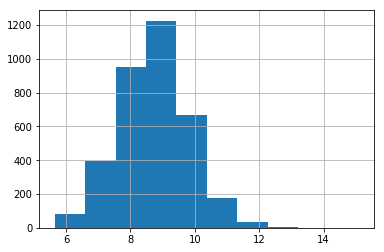

In [24]:
np.log2(rna_prot_embed['AT2_04M_F0'].loc[:,'ProteinLength']).hist()

In [ ]:
fig = plt.figure()
fig.set_size_inches((10, 6))
ax = fig.add_subplot(111)
ax.scatter(data.rna_protein[cell].loc[:,cell],data.rna_protein[cell].loc[:,cell+'_P'])
print(scipy.stats.pearsonr(data.rna_protein[cell].loc[:,cell],data.rna_protein[cell].loc[:,cell+'_P']))
print(scipy.stats.spearmanr(data.rna_protein[cell].loc[:,cell],data.rna_protein[cell].loc[:,cell+'_P']))

In [19]:
rna_prot_embed['AT2_04M_F0'].loc[:,'ProteinLength'].argmax()

 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


('Ttn', 'A2ASS6', 'AT2_04M_F0')

In [20]:
rna_prot_embed['AT2_04M_F0'].loc[:,'ProteinLength']['Ttn']

Majority.protein.IDs  cell      
A2ASS6                AT2_04M_F0    35213
Name: ProteinLength, dtype: int64

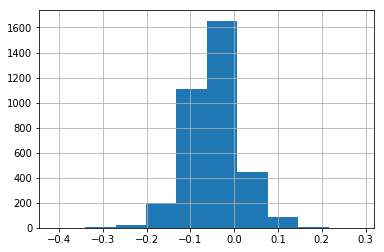

In [9]:
rna_prot_embed['AT2_04M_F0'].loc[:,0].hist()